In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
import os
import glob
import numpy as np
import gzip as gz
import pickle
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram, mask_and_replace
from models.CNN_BiLSTM_Attention import ParallelModel

# GAN implementation : comparison between spectrum and time serie 
https://towardsdatascience.com/synthetic-time-series-data-a-gan-approach-869a984f2239

In [3]:
data_path = '/Users/martinblot/Desktop/sleep-edf-prepared/5-cassette'  ## path towards the 5-cassette file
fp = gz.open(data_path+'/SC4001E0.npz.gz','rb')
data_test = np.load(fp,allow_pickle=True)
fnames = glob.glob(os.path.join(data_path, "*npz.gz"))
devpart = 10
xtrain , xvalid = None , None
ytrain , yvalid = None , None
measurement=data_test['ch_label'][2]

for fn in tqdm(fnames):
    fp = gz.open(fn,'rb')
    data = np.load(fp,allow_pickle=False) # for now, don't care about headers
    x = data['x'][:,:,2] # EEG and EOG
    y = data['y'] # Take the labels
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    devpart = 10
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    if xtrain is None:
        xtrain = np.zeros((1,x.shape[1]))    ##np.zeros((1,x.shape[1],2)) if we include EOG  
        xvalid = np.zeros((1,x.shape[1]))
        ytrain , yvalid = np.zeros(1) , np.zeros(1)
    xvalid = np.concatenate((xvalid,x[idx[:devlim]]), axis=0)
    yvalid = np.concatenate((yvalid,y[idx[:devlim]]), axis=0)
    xtrain = np.concatenate((xtrain,x[idx[devlim:]]), axis=0)
    ytrain = np.concatenate((ytrain,y[idx[devlim:]]), axis=0)
    del x,y

xtrain , xvalid = xtrain[1:] , xvalid[1:]
ytrain , yvalid = ytrain[1:] , yvalid[1:]
xtrain, xvalid = th.FloatTensor(xtrain), th.FloatTensor(xvalid)
ytrain, yvalid = th.IntTensor(ytrain), th.IntTensor(yvalid)

100%|██████████| 153/153 [00:58<00:00,  2.63it/s]


In [5]:
outf="/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck"
fp = open(outf,"wb")
pickle.dump((xtrain , xvalid , ytrain , yvalid), fp)
filepath = '/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck'
xtrain,xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
print(xtrain.shape)

torch.Size([175995, 600])


In [21]:
batch=100
xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:100]),th.tensor(ytrain[:100])
xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:100]),th.tensor(yvalid[:100])

dataset_t = TensorDataset(xtrain_tensor, ytrain_tensor)
train_loader = DataLoader(dataset_t, batch_size= batch, shuffle=True)
dataset_v = TensorDataset(xvalid_tensor, yvalid_tensor)
valid_loader = DataLoader(dataset_v, batch_size= batch, shuffle=True)

/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_43140/860695651.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:100]),th.tensor(ytrain[:100])
/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_43140/860695651.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:100]),th.tensor(yvalid[:100])


In [22]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_dim= output_dim
        # Couches du générateur
        self.GRU = nn.GRU(1, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.gen_block = nn.Linear(2*hidden_dim, output_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x=x.unsqueeze(-1)
        # Passage des données par le GRU
        x, _ = self.GRU(x)
        # Prendre seulement la sortie du dernier pas de temps
        x = x[:, -1]
        # Application de la couche linéaire
        x = self.gen_block(x)
        # Activation
        x = self.activation(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, hidden_dim, n_layers):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # Couches du discriminateur
        self.GRU = nn.GRU(1, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.dis_block = nn.Linear(2*hidden_dim, 1)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x=x.unsqueeze(-1)
        # Passage des données par le GRU
        x, _ = self.GRU(x)
        # Prendre seulement la sortie du dernier pas de temps
        x = x[:, -1]
        # Application de la couche linéaire
        x = self.dis_block(x)
        # Activation
        x = self.activation(x)
        return x


In [23]:
def generator_loss(fake_output, real_batch_labels, criterion):
  loss = criterion(fake_output, real_batch_labels)
  return loss

def discriminator_loss(real_output, fake_output, real_labels, fake_labels, criterion):
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    return real_loss + fake_loss

https://github.com/ydataai/ydata-synthetic/blob/dev/src/ydata_synthetic/synthesizers/timeseries/timegan/model.py

In [24]:
def train_GAN(discriminator, generator, batch, trainloader, hidden_dim, dis_loss, gen_loss, input_dim=600, lr = 0.0002, nepoch = 10):
  real_batch_labels = th.ones((batch, 1))
  fake_batch_labels = th.zeros((batch, 1))
  optim_generator = optim.Adam(generator.parameters(), lr = lr)
  optim_discriminator = optim.Adam(discriminator.parameters(), lr = lr)
  g_losses, d_losses = [], []
  batches_per_epochs=int(input_dim/batch)
  n_steps=batches_per_epochs*nepoch
  for epoch in tqdm(range(n_steps)):
      running_d_loss = 0
      running_g_loss = 0
      for inputs,_ in trainloader:
        z=th.randn((batch,hidden_dim))
        h = generator(z)
        fake_outputs = discriminator(h)
        outputs = discriminator(inputs)
        optim_discriminator.zero_grad()
        d_loss = discriminator_loss(outputs,fake_outputs,real_batch_labels, fake_batch_labels, dis_loss)
        running_d_loss += d_loss.item()
        d_loss.backward()
        optim_discriminator.step()
        optim_generator.zero_grad()
        fake_outputs = discriminator(h.detach())
        g_loss = generator_loss(fake_outputs,real_batch_labels,gen_loss)
        running_g_loss += g_loss.item()
        g_loss.backward()
        optim_generator.step()

      g_losses.append(running_g_loss / len(trainloader))
      d_losses.append(running_d_loss / len(trainloader))

      print(f"Epoch {epoch + 1}/{nepoch} -> "
            f"Generator Loss: {running_g_loss :.4f}, "
            f"Discriminator Loss: {running_d_loss:.4f}")


  return g_losses, d_losses

In [25]:
learning_rate=0.0001
hidden_dim = 128
num_epochs = 10
input_dim=600
n_layers=5

# Instanciation des modèles
generator = Generator(hidden_dim, input_dim, n_layers)
discriminator = Discriminator(hidden_dim,n_layers)

bceloss=nn.BCELoss()
logloss=nn.NLLLoss()

g_losses, d_losses=train_GAN(discriminator, generator, batch, train_loader, hidden_dim, bceloss, bceloss, lr = 0.0002, nepoch = 10)

  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:30<29:37, 30.13s/it]

Epoch 1/10 -> Generator Loss: 0.7273, Discriminator Loss: 1.3886


  3%|▎         | 2/60 [01:00<29:27, 30.47s/it]

Epoch 2/10 -> Generator Loss: 0.7322, Discriminator Loss: 1.3631


  5%|▌         | 3/60 [01:33<29:52, 31.45s/it]

Epoch 3/10 -> Generator Loss: 0.7381, Discriminator Loss: 1.3382


  7%|▋         | 4/60 [02:06<29:54, 32.04s/it]

Epoch 4/10 -> Generator Loss: 0.7458, Discriminator Loss: 1.3126


  8%|▊         | 5/60 [02:36<28:53, 31.52s/it]

Epoch 5/10 -> Generator Loss: 0.7558, Discriminator Loss: 1.2855


 10%|█         | 6/60 [03:09<28:35, 31.77s/it]

Epoch 6/10 -> Generator Loss: 0.7689, Discriminator Loss: 1.2560


 12%|█▏        | 7/60 [03:52<31:18, 35.45s/it]

Epoch 7/10 -> Generator Loss: 0.7855, Discriminator Loss: 1.2233


 13%|█▎        | 8/60 [04:33<32:12, 37.17s/it]

Epoch 8/10 -> Generator Loss: 0.8064, Discriminator Loss: 1.1868


 15%|█▌        | 9/60 [05:14<32:38, 38.41s/it]

Epoch 9/10 -> Generator Loss: 0.8324, Discriminator Loss: 1.1460


 17%|█▋        | 10/60 [05:52<31:54, 38.30s/it]

Epoch 10/10 -> Generator Loss: 0.8644, Discriminator Loss: 1.1004


 18%|█▊        | 11/60 [06:24<29:43, 36.39s/it]

Epoch 11/10 -> Generator Loss: 0.9037, Discriminator Loss: 1.0497


 20%|██        | 12/60 [07:00<28:59, 36.24s/it]

Epoch 12/10 -> Generator Loss: 0.9516, Discriminator Loss: 0.9936


 22%|██▏       | 13/60 [07:36<28:16, 36.09s/it]

Epoch 13/10 -> Generator Loss: 1.0099, Discriminator Loss: 0.9323


 23%|██▎       | 14/60 [08:11<27:33, 35.95s/it]

Epoch 14/10 -> Generator Loss: 1.0804, Discriminator Loss: 0.8660


 25%|██▌       | 15/60 [08:43<26:03, 34.73s/it]

Epoch 15/10 -> Generator Loss: 1.1651, Discriminator Loss: 0.7955


 27%|██▋       | 16/60 [09:21<26:04, 35.55s/it]

Epoch 16/10 -> Generator Loss: 1.2659, Discriminator Loss: 0.7220


 28%|██▊       | 17/60 [09:52<24:30, 34.20s/it]

Epoch 17/10 -> Generator Loss: 1.3844, Discriminator Loss: 0.6471


 30%|███       | 18/60 [10:20<22:47, 32.56s/it]

Epoch 18/10 -> Generator Loss: 1.5210, Discriminator Loss: 0.5728


 32%|███▏      | 19/60 [10:52<22:10, 32.44s/it]

Epoch 19/10 -> Generator Loss: 1.6751, Discriminator Loss: 0.5011


 33%|███▎      | 20/60 [11:22<21:03, 31.59s/it]

Epoch 20/10 -> Generator Loss: 1.8440, Discriminator Loss: 0.4339


 35%|███▌      | 21/60 [11:54<20:32, 31.59s/it]

Epoch 21/10 -> Generator Loss: 2.0240, Discriminator Loss: 0.3728


 37%|███▋      | 22/60 [12:28<20:29, 32.36s/it]

Epoch 22/10 -> Generator Loss: 2.2107, Discriminator Loss: 0.3185


 38%|███▊      | 23/60 [13:12<22:10, 35.95s/it]

Epoch 23/10 -> Generator Loss: 2.3996, Discriminator Loss: 0.2716


 40%|████      | 24/60 [13:48<21:30, 35.86s/it]

Epoch 24/10 -> Generator Loss: 2.5872, Discriminator Loss: 0.2319


 42%|████▏     | 25/60 [14:23<20:52, 35.79s/it]

Epoch 25/10 -> Generator Loss: 2.7712, Discriminator Loss: 0.1994


 43%|████▎     | 26/60 [15:05<21:17, 37.58s/it]

Epoch 26/10 -> Generator Loss: 2.9501, Discriminator Loss: 0.1736


 45%|████▌     | 27/60 [15:43<20:42, 37.64s/it]

Epoch 27/10 -> Generator Loss: 3.1228, Discriminator Loss: 0.1538


 47%|████▋     | 28/60 [16:15<19:14, 36.09s/it]

Epoch 28/10 -> Generator Loss: 3.2877, Discriminator Loss: 0.1387


 48%|████▊     | 29/60 [16:46<17:47, 34.43s/it]

Epoch 29/10 -> Generator Loss: 3.4428, Discriminator Loss: 0.1271


 50%|█████     | 30/60 [17:16<16:34, 33.13s/it]

Epoch 30/10 -> Generator Loss: 3.5863, Discriminator Loss: 0.1176


 52%|█████▏    | 31/60 [17:45<15:27, 32.00s/it]

Epoch 31/10 -> Generator Loss: 3.7169, Discriminator Loss: 0.1095


 53%|█████▎    | 32/60 [18:16<14:40, 31.45s/it]

Epoch 32/10 -> Generator Loss: 3.8344, Discriminator Loss: 0.1023


 55%|█████▌    | 33/60 [18:46<14:01, 31.17s/it]

Epoch 33/10 -> Generator Loss: 3.9393, Discriminator Loss: 0.0959


 57%|█████▋    | 34/60 [19:17<13:26, 31.03s/it]

Epoch 34/10 -> Generator Loss: 4.0324, Discriminator Loss: 0.0902


 58%|█████▊    | 35/60 [19:47<12:50, 30.83s/it]

Epoch 35/10 -> Generator Loss: 4.1146, Discriminator Loss: 0.0851


 60%|██████    | 36/60 [20:17<12:12, 30.53s/it]

Epoch 36/10 -> Generator Loss: 4.1864, Discriminator Loss: 0.0802


 62%|██████▏   | 37/60 [20:52<12:14, 31.94s/it]

Epoch 37/10 -> Generator Loss: 4.2480, Discriminator Loss: 0.0751


 63%|██████▎   | 38/60 [21:30<12:17, 33.54s/it]

Epoch 38/10 -> Generator Loss: 4.2993, Discriminator Loss: 0.0695


 65%|██████▌   | 39/60 [22:02<11:38, 33.25s/it]

Epoch 39/10 -> Generator Loss: 4.3403, Discriminator Loss: 0.0631


 67%|██████▋   | 40/60 [22:35<10:59, 33.00s/it]

Epoch 40/10 -> Generator Loss: 4.3714, Discriminator Loss: 0.0557


 68%|██████▊   | 41/60 [23:06<10:16, 32.45s/it]

Epoch 41/10 -> Generator Loss: 4.3939, Discriminator Loss: 0.0479


 70%|███████   | 42/60 [23:38<09:43, 32.43s/it]

Epoch 42/10 -> Generator Loss: 4.4098, Discriminator Loss: 0.0405


 72%|███████▏  | 43/60 [24:09<09:05, 32.08s/it]

Epoch 43/10 -> Generator Loss: 4.4210, Discriminator Loss: 0.0340


 73%|███████▎  | 44/60 [24:41<08:29, 31.84s/it]

Epoch 44/10 -> Generator Loss: 4.4290, Discriminator Loss: 0.0281


 75%|███████▌  | 45/60 [25:10<07:47, 31.20s/it]

Epoch 45/10 -> Generator Loss: 4.4372, Discriminator Loss: 0.0229


 77%|███████▋  | 46/60 [41:23<1:13:09, 313.51s/it]

Epoch 46/10 -> Generator Loss: 4.4518, Discriminator Loss: 0.0188


 78%|███████▊  | 47/60 [41:55<49:37, 229.07s/it]  

Epoch 47/10 -> Generator Loss: 4.4792, Discriminator Loss: 0.0163


 80%|████████  | 48/60 [42:24<33:50, 169.24s/it]

Epoch 48/10 -> Generator Loss: 4.5234, Discriminator Loss: 0.0149


 82%|████████▏ | 49/60 [42:55<23:23, 127.55s/it]

Epoch 49/10 -> Generator Loss: 4.5848, Discriminator Loss: 0.0139


 83%|████████▎ | 50/60 [43:23<16:19, 97.95s/it] 

Epoch 50/10 -> Generator Loss: 4.6612, Discriminator Loss: 0.0129


 85%|████████▌ | 51/60 [43:53<11:36, 77.36s/it]

Epoch 51/10 -> Generator Loss: 4.7492, Discriminator Loss: 0.0120


 87%|████████▋ | 52/60 [44:22<08:24, 63.05s/it]

Epoch 52/10 -> Generator Loss: 4.8444, Discriminator Loss: 0.0111


 88%|████████▊ | 53/60 [44:53<06:12, 53.25s/it]

Epoch 53/10 -> Generator Loss: 4.9433, Discriminator Loss: 0.0102


 90%|█████████ | 54/60 [45:24<04:40, 46.75s/it]

Epoch 54/10 -> Generator Loss: 5.0430, Discriminator Loss: 0.0093


 92%|█████████▏| 55/60 [45:54<03:27, 41.50s/it]

Epoch 55/10 -> Generator Loss: 5.1407, Discriminator Loss: 0.0086


 93%|█████████▎| 56/60 [46:26<02:35, 38.84s/it]

Epoch 56/10 -> Generator Loss: 5.2349, Discriminator Loss: 0.0079


 95%|█████████▌| 57/60 [47:01<01:52, 37.51s/it]

Epoch 57/10 -> Generator Loss: 5.3247, Discriminator Loss: 0.0074


 97%|█████████▋| 58/60 [47:32<01:11, 35.78s/it]

Epoch 58/10 -> Generator Loss: 5.4096, Discriminator Loss: 0.0069


 98%|█████████▊| 59/60 [48:07<00:35, 35.35s/it]

Epoch 59/10 -> Generator Loss: 5.4890, Discriminator Loss: 0.0064


100%|██████████| 60/60 [48:38<00:00, 48.65s/it]

Epoch 60/10 -> Generator Loss: 5.5634, Discriminator Loss: 0.0060


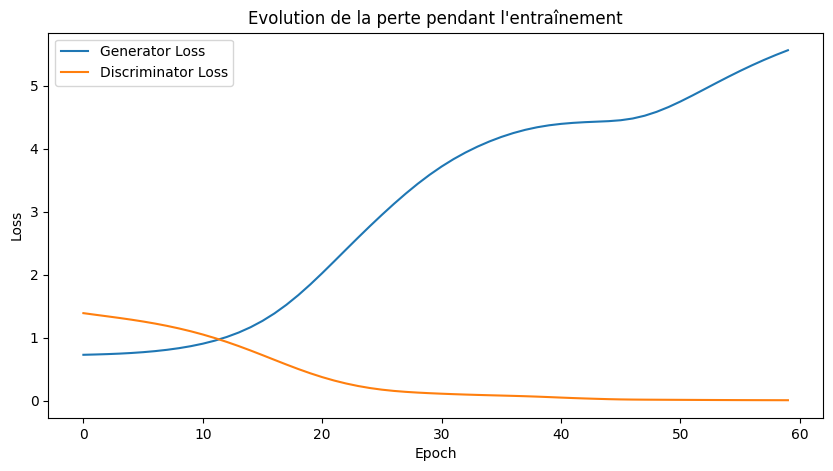

In [26]:

    # Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()